## Importing Libraries

In [11]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input, concatenate, Reshape, SimpleRNN
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras import regularizers
from sklearn.metrics import f1_score, precision_score, recall_score, precision_recall_curve, roc_auc_score, roc_curve, accuracy_score
from sklearn.utils import shuffle, resample
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.callbacks import History, EarlyStopping
from imblearn.under_sampling import RandomUnderSampler

## Reading the csv file and handling NaNs

In [3]:
df = pd.read_csv(r'f1dataset1.csv', encoding='utf-8')

# HANDLING NANs
df['laptime'] = np.where(df['laptime'].isna(), 0.0, df['laptime'])
df['race_progress'] = np.where(df['race_progress'].isna(), 0.0, df['race_progress'])
df['tyreageprogress'] = np.where(df['tyreageprogress'].isna(), 0.0, df['tyreageprogress'])

## Evalutation pipeline with preprocessing

In [4]:
# shuffle data
shuffled_data = df.sample(frac=1, random_state=42)  # Set random_state for reproducibility

C:\Users\charm\anaconda3\lib\site-packages\pandas\core\indexing.py:1835: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


Epoch 1/10
75/75 [==============================] - 2s 9ms/step - loss: 18.8700 - accuracy: 0.9684 - val_loss: 12.8141 - val_accuracy: 1.0000
Epoch 2/10
75/75 [==============================] - 0s 6ms/step - loss: 8.5064 - accuracy: 0.9473 - val_loss: 5.1274 - val_accuracy: 0.6212
Epoch 3/10
75/75 [==============================] - 1s 7ms/step - loss: 2.6233 - accuracy: 0.9659 - val_loss: 1.3677 - val_accuracy: 0.6364
Epoch 4/10
75/75 [==============================] - 1s 7ms/step - loss: 0.8102 - accuracy: 0.9401 - val_loss: 0.6370 - val_accuracy: 1.0000
Epoch 5/10
75/75 [==============================] - 0s 6ms/step - loss: 0.6489 - accuracy: 0.9439 - val_loss: 0.8452 - val_accuracy: 0.8674
Epoch 6/10
75/75 [==============================] - 0s 6ms/step - loss: 0.5167 - accuracy: 0.9962 - val_loss: 0.4713 - val_accuracy: 1.0000
Epoch 7/10
75/75 [==============================] - 1s 7ms/step - loss: 0.4484 - accuracy: 1.0000 - val_loss: 0.4333 - val_accuracy: 1.0000
Epoch 8/10
75/75 [

C:\Users\charm\anaconda3\lib\site-packages\pandas\core\indexing.py:1835: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


142/142 [==============================] - 0s 3ms/step
Epoch 1/10
75/75 [==============================] - 2s 9ms/step - loss: 18.7577 - accuracy: 0.9431 - val_loss: 12.6481 - val_accuracy: 0.9773
Epoch 2/10
75/75 [==============================] - 0s 5ms/step - loss: 8.3072 - accuracy: 0.9848 - val_loss: 4.5757 - val_accuracy: 1.0000
Epoch 3/10
75/75 [==============================] - 0s 4ms/step - loss: 2.5494 - accuracy: 0.9587 - val_loss: 1.0312 - val_accuracy: 1.0000
Epoch 4/10
75/75 [==============================] - 0s 5ms/step - loss: 0.8065 - accuracy: 0.9237 - val_loss: 0.6341 - val_accuracy: 1.0000
Epoch 5/10
75/75 [==============================] - 0s 6ms/step - loss: 0.6137 - accuracy: 0.9764 - val_loss: 0.5527 - val_accuracy: 1.0000
Epoch 6/10
75/75 [==============================] - 0s 7ms/step - loss: 0.6850 - accuracy: 0.7913 - val_loss: 0.7932 - val_accuracy: 0.5000
Epoch 7/10
75/75 [==============================] - 0s 5ms/step - loss: 0.7729 - accuracy: 0.4992 - val

C:\Users\charm\anaconda3\lib\site-packages\pandas\core\indexing.py:1835: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


142/142 [==============================] - 0s 2ms/step
Epoch 1/10
75/75 [==============================] - 2s 9ms/step - loss: 18.6877 - accuracy: 0.9637 - val_loss: 13.1194 - val_accuracy: 0.6667
Epoch 2/10
75/75 [==============================] - 0s 5ms/step - loss: 8.4419 - accuracy: 0.9431 - val_loss: 4.7582 - val_accuracy: 1.0000
Epoch 3/10
75/75 [==============================] - 0s 7ms/step - loss: 2.6122 - accuracy: 0.9810 - val_loss: 1.2890 - val_accuracy: 0.7614
Epoch 4/10
75/75 [==============================] - 1s 7ms/step - loss: 0.7903 - accuracy: 0.9646 - val_loss: 0.6354 - val_accuracy: 1.0000
Epoch 5/10
75/75 [==============================] - 0s 5ms/step - loss: 0.6373 - accuracy: 0.9646 - val_loss: 0.9546 - val_accuracy: 0.5189
Epoch 6/10
75/75 [==============================] - 0s 6ms/step - loss: 0.5520 - accuracy: 0.9764 - val_loss: 0.4951 - val_accuracy: 1.0000
Epoch 7/10
75/75 [==============================] - 0s 6ms/step - loss: 0.6099 - accuracy: 0.9102 - val

C:\Users\charm\anaconda3\lib\site-packages\pandas\core\indexing.py:1835: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


142/142 [==============================] - 0s 3ms/step
Epoch 1/10
75/75 [==============================] - 3s 10ms/step - loss: 18.5805 - accuracy: 0.9591 - val_loss: 12.5013 - val_accuracy: 1.0000
Epoch 2/10
75/75 [==============================] - 1s 7ms/step - loss: 8.3356 - accuracy: 0.9325 - val_loss: 4.8191 - val_accuracy: 0.7917
Epoch 3/10
75/75 [==============================] - 1s 7ms/step - loss: 2.5374 - accuracy: 0.9848 - val_loss: 1.0680 - val_accuracy: 1.0000
Epoch 4/10
75/75 [==============================] - 0s 6ms/step - loss: 0.8292 - accuracy: 0.9073 - val_loss: 0.6904 - val_accuracy: 1.0000
Epoch 5/10
75/75 [==============================] - 0s 6ms/step - loss: 0.6459 - accuracy: 0.9578 - val_loss: 0.5670 - val_accuracy: 1.0000
Epoch 6/10
75/75 [==============================] - 0s 5ms/step - loss: 0.6807 - accuracy: 0.8246 - val_loss: 1.0274 - val_accuracy: 0.5152
Epoch 7/10
75/75 [==============================] - 0s 5ms/step - loss: 0.8024 - accuracy: 0.5118 - va

C:\Users\charm\anaconda3\lib\site-packages\pandas\core\indexing.py:1835: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


142/142 [==============================] - 0s 3ms/step
Epoch 1/10
75/75 [==============================] - 2s 10ms/step - loss: 18.4005 - accuracy: 0.9524 - val_loss: 12.3222 - val_accuracy: 1.0000
Epoch 2/10
75/75 [==============================] - 0s 6ms/step - loss: 8.1166 - accuracy: 0.9671 - val_loss: 4.5022 - val_accuracy: 0.9508
Epoch 3/10
75/75 [==============================] - 0s 6ms/step - loss: 2.4327 - accuracy: 0.9599 - val_loss: 0.9975 - val_accuracy: 1.0000
Epoch 4/10
75/75 [==============================] - 0s 6ms/step - loss: 0.8024 - accuracy: 0.9477 - val_loss: 0.8277 - val_accuracy: 0.7235
Epoch 5/10
75/75 [==============================] - 0s 6ms/step - loss: 0.7473 - accuracy: 0.8259 - val_loss: 0.8320 - val_accuracy: 0.5152
Epoch 6/10
75/75 [==============================] - 0s 7ms/step - loss: 0.7714 - accuracy: 0.7707 - val_loss: 0.8638 - val_accuracy: 0.5076
Epoch 7/10
75/75 [==============================] - 0s 5ms/step - loss: 0.6092 - accuracy: 0.9338 - va

C:\Users\charm\anaconda3\lib\site-packages\pandas\core\indexing.py:1835: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


142/142 [==============================] - 1s 4ms/step
Epoch 1/10
75/75 [==============================] - 3s 15ms/step - loss: 18.9279 - accuracy: 0.9595 - val_loss: 12.7554 - val_accuracy: 1.0000
Epoch 2/10
75/75 [==============================] - 1s 10ms/step - loss: 8.4851 - accuracy: 0.9857 - val_loss: 4.6818 - val_accuracy: 1.0000
Epoch 3/10
75/75 [==============================] - 1s 9ms/step - loss: 2.5622 - accuracy: 0.9815 - val_loss: 1.1063 - val_accuracy: 1.0000
Epoch 4/10
75/75 [==============================] - 1s 8ms/step - loss: 0.7737 - accuracy: 0.9642 - val_loss: 0.7970 - val_accuracy: 0.8409
Epoch 5/10
75/75 [==============================] - 1s 7ms/step - loss: 0.6203 - accuracy: 0.9595 - val_loss: 0.5386 - val_accuracy: 1.0000
Epoch 6/10
75/75 [==============================] - 1s 7ms/step - loss: 0.5474 - accuracy: 0.9650 - val_loss: 0.4861 - val_accuracy: 1.0000
Epoch 7/10
75/75 [==============================] - 1s 8ms/step - loss: 0.4517 - accuracy: 1.0000 - v

C:\Users\charm\anaconda3\lib\site-packages\pandas\core\indexing.py:1835: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


142/142 [==============================] - 1s 3ms/step
Epoch 1/10
75/75 [==============================] - 3s 10ms/step - loss: 18.8475 - accuracy: 0.9650 - val_loss: 12.7852 - val_accuracy: 1.0000
Epoch 2/10
75/75 [==============================] - 0s 7ms/step - loss: 8.5567 - accuracy: 0.9515 - val_loss: 4.7707 - val_accuracy: 1.0000
Epoch 3/10
75/75 [==============================] - 1s 7ms/step - loss: 2.6474 - accuracy: 0.9718 - val_loss: 1.0751 - val_accuracy: 1.0000
Epoch 4/10
75/75 [==============================] - 1s 7ms/step - loss: 0.8091 - accuracy: 0.9549 - val_loss: 0.6433 - val_accuracy: 1.0000
Epoch 5/10
75/75 [==============================] - 0s 6ms/step - loss: 0.6814 - accuracy: 0.9140 - val_loss: 0.8503 - val_accuracy: 0.6882
Epoch 6/10
75/75 [==============================] - 1s 7ms/step - loss: 0.6061 - accuracy: 0.9469 - val_loss: 0.5094 - val_accuracy: 1.0000
Epoch 7/10
75/75 [==============================] - 0s 6ms/step - loss: 0.5516 - accuracy: 0.9617 - va

C:\Users\charm\anaconda3\lib\site-packages\pandas\core\indexing.py:1835: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


142/142 [==============================] - 0s 3ms/step
Epoch 1/10
75/75 [==============================] - 3s 10ms/step - loss: 19.1194 - accuracy: 0.9718 - val_loss: 13.0277 - val_accuracy: 1.0000
Epoch 2/10
75/75 [==============================] - 0s 7ms/step - loss: 8.7393 - accuracy: 0.9768 - val_loss: 5.1272 - val_accuracy: 0.8935
Epoch 3/10
75/75 [==============================] - 0s 6ms/step - loss: 2.7211 - accuracy: 0.9819 - val_loss: 1.1647 - val_accuracy: 1.0000
Epoch 4/10
75/75 [==============================] - 1s 7ms/step - loss: 0.7936 - accuracy: 0.9764 - val_loss: 0.6379 - val_accuracy: 1.0000
Epoch 5/10
75/75 [==============================] - 1s 9ms/step - loss: 0.7047 - accuracy: 0.8968 - val_loss: 0.9063 - val_accuracy: 0.5095
Epoch 6/10
75/75 [==============================] - 1s 8ms/step - loss: 0.7037 - accuracy: 0.8508 - val_loss: 0.5361 - val_accuracy: 1.0000
Epoch 7/10
75/75 [==============================] - 1s 7ms/step - loss: 0.5921 - accuracy: 0.9212 - va

C:\Users\charm\anaconda3\lib\site-packages\pandas\core\indexing.py:1835: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


142/142 [==============================] - 0s 3ms/step
Epoch 1/10
75/75 [==============================] - 3s 16ms/step - loss: 18.1973 - accuracy: 0.9802 - val_loss: 12.1857 - val_accuracy: 1.0000
Epoch 2/10
75/75 [==============================] - 1s 7ms/step - loss: 8.0687 - accuracy: 0.9536 - val_loss: 4.4006 - val_accuracy: 1.0000
Epoch 3/10
75/75 [==============================] - 1s 7ms/step - loss: 2.4471 - accuracy: 0.9625 - val_loss: 1.0456 - val_accuracy: 1.0000
Epoch 4/10
75/75 [==============================] - 1s 7ms/step - loss: 0.7608 - accuracy: 0.9743 - val_loss: 0.6344 - val_accuracy: 1.0000
Epoch 5/10
75/75 [==============================] - 1s 7ms/step - loss: 0.6275 - accuracy: 0.9646 - val_loss: 1.1468 - val_accuracy: 0.5247
Epoch 6/10
75/75 [==============================] - 0s 6ms/step - loss: 0.6801 - accuracy: 0.8769 - val_loss: 0.9458 - val_accuracy: 0.5171
Epoch 7/10
75/75 [==============================] - 1s 7ms/step - loss: 0.6672 - accuracy: 0.8319 - va

C:\Users\charm\anaconda3\lib\site-packages\pandas\core\indexing.py:1835: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


142/142 [==============================] - 1s 3ms/step
Epoch 1/10
75/75 [==============================] - 3s 11ms/step - loss: 18.7019 - accuracy: 0.9756 - val_loss: 12.5887 - val_accuracy: 1.0000
Epoch 2/10
75/75 [==============================] - 1s 7ms/step - loss: 8.3255 - accuracy: 0.9882 - val_loss: 4.5672 - val_accuracy: 1.0000
Epoch 3/10
75/75 [==============================] - 0s 6ms/step - loss: 2.5198 - accuracy: 0.9726 - val_loss: 1.0773 - val_accuracy: 1.0000
Epoch 4/10
75/75 [==============================] - 1s 7ms/step - loss: 0.7659 - accuracy: 0.9663 - val_loss: 1.0754 - val_accuracy: 0.6236
Epoch 5/10
75/75 [==============================] - 0s 7ms/step - loss: 0.8447 - accuracy: 0.7122 - val_loss: 0.7645 - val_accuracy: 0.8403
Epoch 6/10
75/75 [==============================] - 0s 7ms/step - loss: 0.7934 - accuracy: 0.6599 - val_loss: 0.7543 - val_accuracy: 0.9316
Epoch 7/10
75/75 [==============================] - 1s 7ms/step - loss: 0.5817 - accuracy: 0.9600 - va

C:\Users\charm\anaconda3\lib\site-packages\pandas\core\indexing.py:1835: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


142/142 [==============================] - 0s 3ms/step
Average Test Accuracy: 0.9999557717823973
Average Test Precision: 0.9999557918952746
Average Test Recall: 0.9999557717823973
Average Test F1 Score: 0.9999555998988896


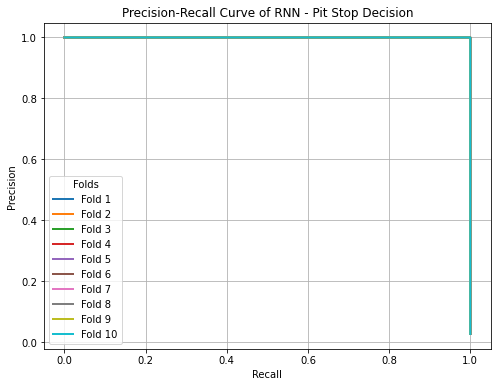

Average Test AUC: 1.0


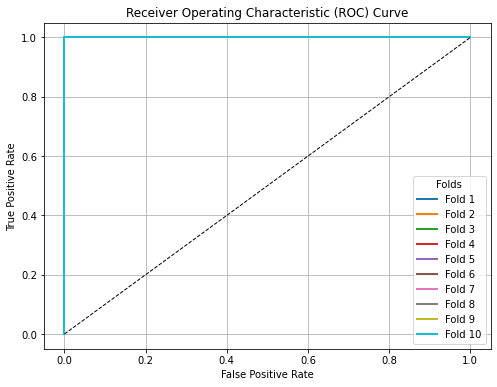

In [12]:
# Set the seed value
np.random.seed(42)

# Separate test races
test_races = shuffled_data['race_id'].unique()[:10]  # 10 test races
excluded_races = test_races.tolist()

# Exclude test races from the dataset
train_data = shuffled_data[~shuffled_data['race_id'].isin(test_races)]
test_data = shuffled_data[shuffled_data['race_id'].isin(test_races)]

# Separate input features (X) and target variable (y) for the training set
X_train = train_data[['race_progress', 'tyreageprogress', 'is_leader', 'relativecompound', 'racetrackcat', 'fcystatus', 'remaining_pit_stops', 'pursuer_tyre_change', 'close_ahead']]
y_train = train_data['pitstop']

# Separate categorical and numerical features
cat_features = ['is_leader', 'relativecompound', 'racetrackcat', 'fcystatus', 'remaining_pit_stops', 'pursuer_tyre_change', 'close_ahead']
num_features = ['race_progress', 'tyreageprogress']

# Perform preprocessing on numerical features
scaler = StandardScaler()
X_train.loc[:, num_features] = scaler.fit_transform(X_train[num_features])

# Perform preprocessing on categorical features
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
X_train_encoded = encoder.fit_transform(X_train[cat_features])

# Combine preprocessed numerical and categorical features
X_train_processed = np.concatenate((X_train_encoded, X_train[num_features].values), axis=1)

# Create an instance of LabelEncoder
label_encoder = LabelEncoder()

# Encode the categorical labels into integer values
y_train_encoded = label_encoder.fit_transform(y_train)

# Perform undersampling on the training data
rus = RandomUnderSampler(random_state=42)
X_train_processed_undersampled, y_train_encoded_undersampled = rus.fit_resample(X_train_processed, y_train_encoded)

# Define the number of folds for cross-validation
n_folds = 10

# Initialize StratifiedKFold with the desired number of folds
stratified_kfold = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

# Initialize lists to store evaluation results
test_accuracy_scores = []
test_precision_scores = []
test_recall_scores = []
test_f1_scores = []

precision_per_fold = []
recall_per_fold = []
auc_scores = []
roc_curves = []


# Iterate over the folds
for train_index, val_index in stratified_kfold.split(X_train_processed_undersampled, y_train_encoded_undersampled):
    # Get the training and validation subsets for the current fold
    X_train_fold = X_train_processed_undersampled[train_index]
    y_train_fold = y_train_encoded_undersampled[train_index]

    X_val_fold = X_train_processed_undersampled[val_index]
    y_val_fold = y_train_encoded_undersampled[val_index]

    # Reshape the input data 
    X_train_reshaped = X_train_fold.reshape(X_train_fold.shape[0], X_train_fold.shape[1], 1)
    X_val_reshaped = X_val_fold.reshape(X_val_fold.shape[0], X_val_fold.shape[1], 1)

    early_stopping = EarlyStopping(patience=3, restore_best_weights=True)

    rnn_model = Sequential()
    rnn_model.add(SimpleRNN(64, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2]),
                           kernel_regularizer=regularizers.l1_l2(l1=0.09, l2=0.01)))  # L1 and L2 regularization
    rnn_model.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.09, l2=0.01)))  # L1 and L2 regularization
    rnn_model.add(Dense(1, activation='sigmoid'))

    # Compile the model
    rnn_model.compile(optimizer='nadam', loss='binary_crossentropy', metrics=['accuracy'])

    # Train the model
    rnn_model.fit(X_train_reshaped, y_train_fold, validation_data=(X_val_reshaped, y_val_fold),
                  batch_size=32,
                  epochs=10,
                  callbacks=[early_stopping])


    # Perform preprocessing on the test set using the same transformations
    X_test = test_data[['race_progress', 'tyreageprogress', 'is_leader', 'relativecompound', 'racetrackcat', 'fcystatus', 'remaining_pit_stops', 'pursuer_tyre_change', 'close_ahead']]
    y_test = test_data['pitstop']
    X_test.loc[:, num_features] = scaler.transform(X_test[num_features])
    X_test_encoded = encoder.transform(X_test[cat_features])
    X_test_processed = np.concatenate((X_test_encoded, X_test[num_features].values), axis=1)
    X_test_reshaped = X_test_processed.reshape(X_test_processed.shape[0], X_test_processed.shape[1], 1)

    # Evaluate the model on the test set and calculate F1 score
    y_test_pred = np.round(rnn_model.predict(X_test_reshaped)).astype(int)

    # Calculate evaluation metrics for the test data
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_precision = precision_score(y_test, y_test_pred, average='weighted', zero_division=0)
    test_recall = recall_score(y_test, y_test_pred, average='weighted')
    test_f1 = f1_score(y_test, y_test_pred, average='weighted')

    # Store evaluation metrics for the test data
    test_accuracy_scores.append(test_accuracy)
    test_precision_scores.append(test_precision)
    test_recall_scores.append(test_recall)
    test_f1_scores.append(test_f1)
    
    # Evaluate the model on the test set and calculate probabilities
    y_test_prob = rnn_model.predict(X_test_reshaped)

    # Calculate precision and recall values for the fold
    precision, recall, _ = precision_recall_curve(y_test, y_test_prob)
    precision_per_fold.append(precision)
    recall_per_fold.append(recall)

    # Calculate AUC for the test data
    test_auc = roc_auc_score(y_test, y_test_prob)
    auc_scores.append(test_auc)

    # Calculate ROC curve for the fold
    fpr, tpr, _ = roc_curve(y_test, y_test_prob)
    roc_curves.append((fpr, tpr))

# Calculate and print the average evaluation metrics for the test data
print('Average Test Accuracy:', np.mean(test_accuracy_scores))
print('Average Test Precision:', np.mean(test_precision_scores))
print('Average Test Recall:', np.mean(test_recall_scores))
print('Average Test F1 Score:', np.mean(test_f1_scores))

# Plot Precision-Recall curves for each fold
plt.figure(figsize=(8, 6))
for i in range(n_folds):
    plt.plot(recall_per_fold[i], precision_per_fold[i], lw=2, label=f'Fold {i+1}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve of RNN - Pit Stop Decision')
plt.legend(title='Folds', loc='lower left')
plt.grid(True)
plt.show()

# Calculate and print the average AUC score for the test data
print('Average Test AUC:', np.mean(auc_scores))

# Plot ROC curves for each fold
plt.figure(figsize=(8, 6))
for i in range(n_folds):
    fpr, tpr = roc_curves[i]
    plt.plot(fpr, tpr, lw=2, label=f'Fold {i+1}')
plt.plot([0, 1], [0, 1], color='black', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(title='Folds', loc='lower right')
plt.grid(True)
plt.show()